# Лабораторная работа №1

## 1. Скопировать проект по ссылке в локальную среду выполнения

In [1]:
!git clone https://github.com/ewatson2/EEL6812_DeepFool_Project

fatal: destination path 'EEL6812_DeepFool_Project' already exists and is not an empty directory.


## 2. Сменить директорию исполнения на вновь созданную папку

In [2]:
cd /content/EEL6812_DeepFool_Project

/content/EEL6812_DeepFool_Project


In [3]:
ls -a

./         .git/                 models/                   README.md  weights/
../        images/               Model_Training_Adv.ipynb  results/
datasets/  Model_Demo_Adv.ipynb  Model_Training.ipynb      utils/


## 3. Выполнить импорт библиотек

In [4]:
import json
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision import transforms

## 4. Выполнить импорт вспомогательных библиотек из локальных файлов проекта

In [5]:
from models.project_models import FC_500_150, LeNet_CIFAR, LeNet_MNIST, Net
from utils.project_utils import get_clip_bounds, evaluate_attack, display_attack

## 5. Установить случайное рандомное значение в виде переменной rand_seed

In [6]:
rand_seed = 17

## 6. Установить указанное значение для np.random.seed и torch.manual_seed

In [7]:
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

## 7. Использовать в качестсве устройства видеокарту

In [8]:
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(rand_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ",device)

device:  cuda


## 8. Загрузить датасет MNIST

In [9]:
mnist_mean = 0.5  # среднее значение
mnist_std = 0.5   # стандартное отклонение для нормализации
mnist_dim = 28    # каждое изображение

In [10]:
mnist_min, mnist_max = get_clip_bounds(mnist_mean, mnist_std, mnist_dim)  #get clip bounds вычисляет min/max пикселей после нормализации
mnist_min = mnist_min.to(device)
mnist_max = mnist_max.to(device)

In [11]:
mnist_tf = transforms.Compose([
    transforms.ToTensor(),          # изображение в тензор
    transforms.Normalize(mean=mnist_mean, std=mnist_std)  # нормализация данных
])

In [12]:
mnist_tf_train = transforms.Compose([
    transforms.RandomHorizontalFlip(), transforms.ToTensor(),  # случайо отражение по горизонтали(аугментация данных для ораничения перебучения)
    transforms.Normalize( mean=mnist_mean, std=mnist_std)
])

In [13]:
mnist_tf_inv = transforms.Compose([
    transforms.Normalize( mean=0.0, std=np.divide(1.0, mnist_std)),
    transforms.Normalize( mean=np.multiply(-1.0, mnist_std), std=1.0) # инврсия для возврщения читаемости изображения после нормализации
])

In [14]:
mnist_temp = datasets.MNIST(
    root='datasets/mnist',
    train=True,
    download=True,
    transform=mnist_tf_train
    )

mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])

mnist_test = datasets.MNIST(
    root='datasets/mnist',
    train=False,
    download=True,
    transform=mnist_tf
    )

## 9. Загрузить датасет CIFAR-10

In [15]:
cifar_mean = [0.491, 0.482, 0.447]
cifar_std = [0.202, 0.199, 0.201]
cifar_dim = 32    #цвеные изображение 32 на 32 пикселя

In [16]:
cifar_min, cifar_max = get_clip_bounds(cifar_mean, cifar_std, cifar_dim)
cifar_min = cifar_min.to(device)
cifar_max = cifar_max.to(device)

In [17]:
cifar_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar_mean, std=cifar_std)
])

In [18]:
cifar_tf_train = transforms.Compose([
    transforms.RandomCrop(size=cifar_dim, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar_mean, std=cifar_std)
])

In [19]:
cifar_tf_inv = transforms.Compose([
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=np.divide(1.0, cifar_std)),
    transforms.Normalize(mean=np.multiply(-1.0, cifar_mean), std=[1.0, 1.0, 1.0])
])

In [20]:
cifar_temp = datasets.CIFAR10(
    root='datasets/cifar-10',
    train=True,
    download=True,
    transform=cifar_tf_train
)

cifar_train, cifar_val = random_split(cifar_temp, [40000, 10000])

cifar_test = datasets.CIFAR10(
    root='datasets/cifar-10',
    train=False,
    download=True,
    transform=cifar_tf
)

In [21]:
cifar_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

## 10. Выполнить настройку и загрузку DataLoader

In [22]:
batch_size = 64
workers = 4

In [23]:
mnist_loader_train = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=workers)
mnist_loader_val = DataLoader(mnist_val, batch_size=batch_size, shuffle=False, num_workers=workers)
mnist_loader_test = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=workers)

cifar_loader_train = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=workers)
cifar_loader_val = DataLoader(cifar_val, batch_size=batch_size, shuffle=False, num_workers=workers)
cifar_loader_test = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=workers)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 11. Загрузить и оценить стойкость модели Network-In-Network Model к FGSM и DeepFool атакам на основе датасета CIFAR-10


In [24]:
deep_args = {
    'overshoot': 0.02,
    'steps': 50,
    'device': device
}

In [25]:
fgsm_eps = 0.2

model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth',map_location=torch.device('cpu')))

evaluate_attack('cifar_nin_fgsm.csv','results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)

print('')

evaluate_attack('cifar_nin_deepfool.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)

FGSM Test Error : 81.29%
FGSM Robustness : 1.77e-01
FGSM Time (All Images) : 0.67 s
FGSM Time (Per Image) : 67.07 us

DeepFool Test Error : 93.76%
DeepFool Robustness : 2.12e-02
DeepFool Time (All Images) : 185.12 s
DeepFool Time (Per Image) : 18.51 ms


In [26]:
if device.type == 'cuda': torch.cuda.empty_cache()

## 12. Загрузить и оценить стойкость модели LeNet к FGSM и DeepFool атакам на основе датасета CIFAR-10

In [27]:
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)

model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', map_location=torch.device('cpu')))

evaluate_attack('cifar_lenet_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max,
fgsm_eps, is_fgsm=True)

print('')

evaluate_attack('cifar_lenet_deepfool.csv', 'results', device, model,
cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)

FGSM Test Error : 91.71%
FGSM Robustness : 8.90e-02
FGSM Time (All Images) : 0.40 s
FGSM Time (Per Image) : 40.08 us

DeepFool Test Error : 87.81%
DeepFool Robustness : 1.78e-02
DeepFool Time (All Images) : 73.27 s
DeepFool Time (Per Image) : 7.33 ms


In [28]:
if device.type == 'cuda': torch.cuda.empty_cache()

## 13. Выполнить оценку атакующих примеров для сетей

### LeNet

In [29]:
deep_args = [10, 0.02, 1.0, 50]

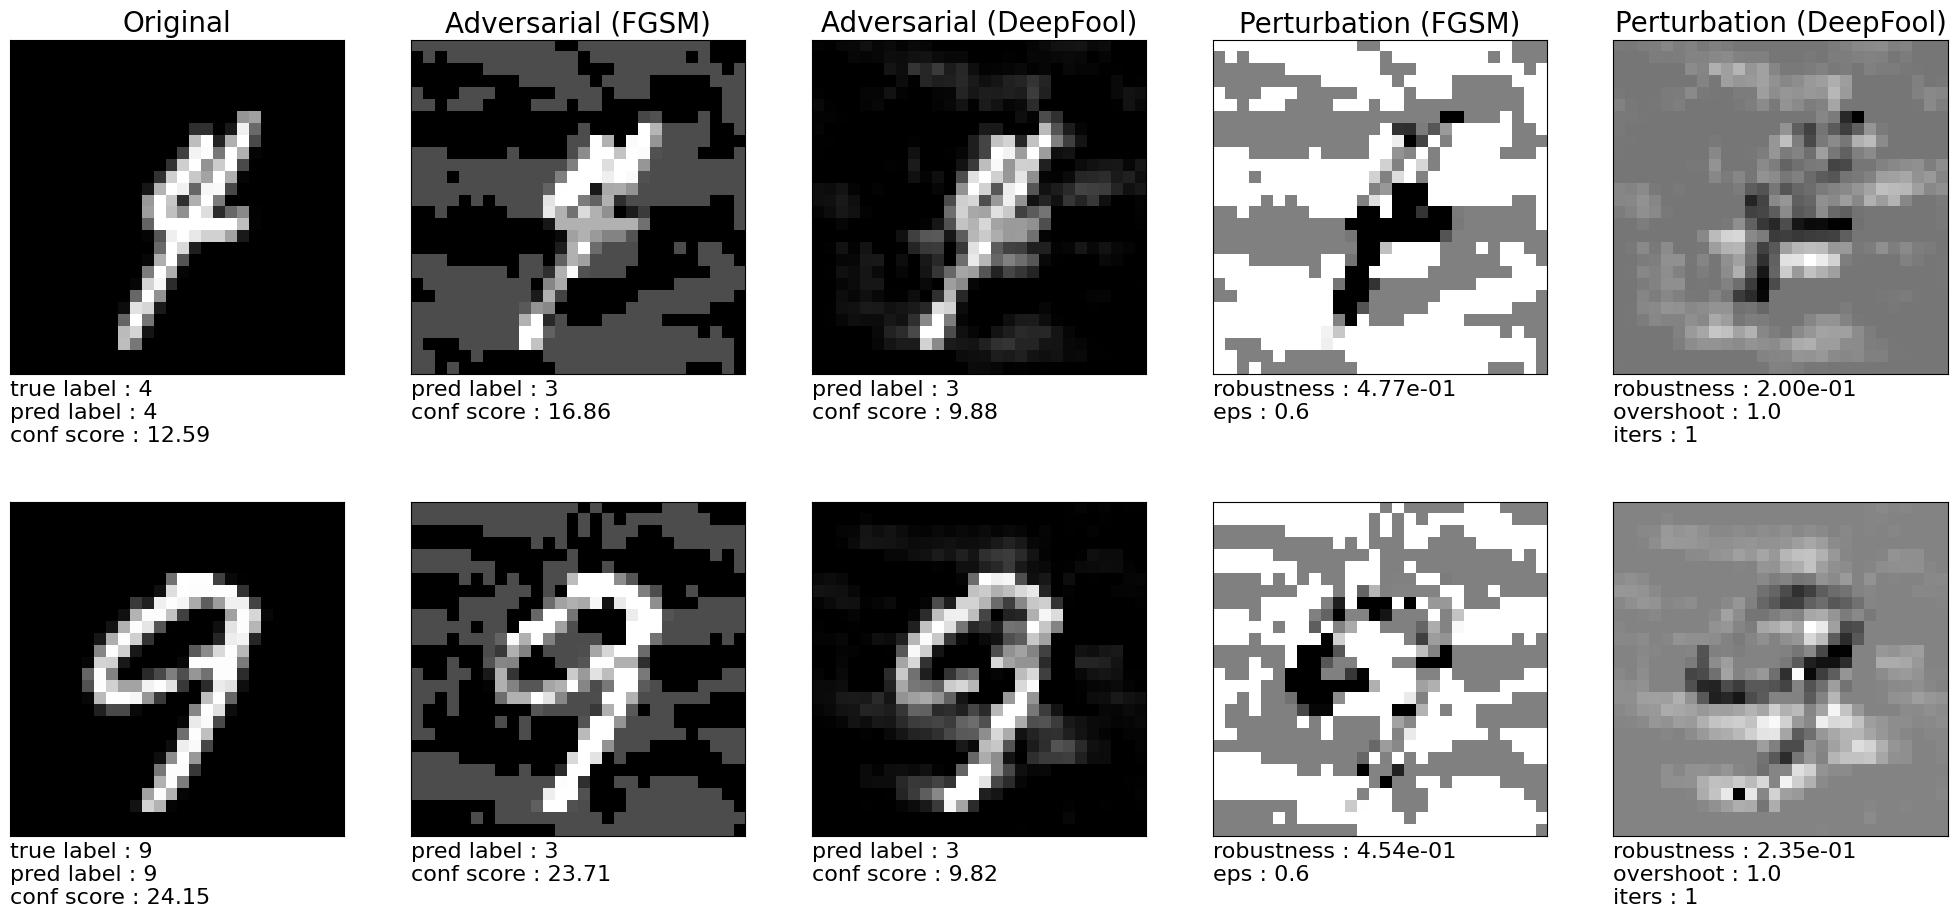

In [31]:
fgsm_eps = 0.6

model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

# Выполнение и отображение атак
display_attack(
    device,
    model,
    mnist_test,
    mnist_tf_inv,
    mnist_min,
    mnist_max,
    fgsm_eps,
    deep_args,
    has_labels=False,
    l2_norm=True,
    pert_scale=1.0,
    fig_rows=2,
    fig_width=25,
    fig_height=11)

In [32]:
if device.type == 'cuda': torch.cuda.empty_cache()

### FCNet

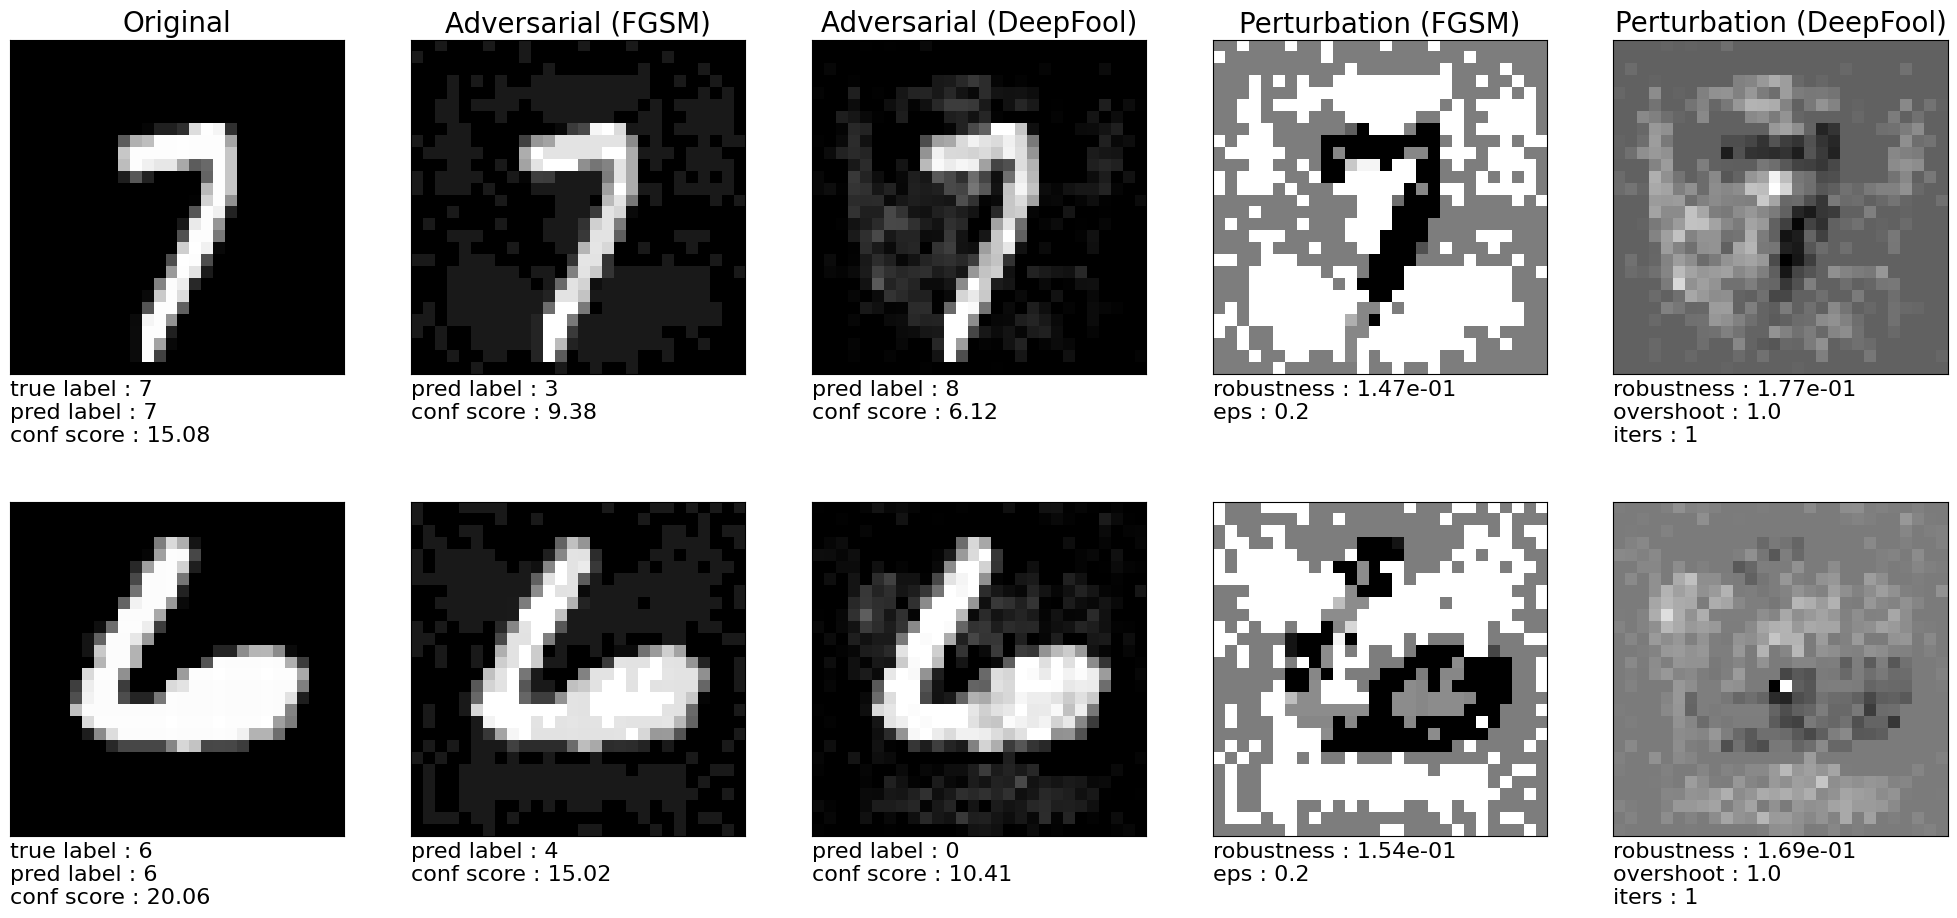

In [33]:
fgsm_eps = 0.2

model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

display_attack(
    device,
    model,
    mnist_test,
    mnist_tf_inv,
    mnist_min,
    mnist_max,
    fgsm_eps,
    deep_args,
    has_labels=False,
    l2_norm=True,
    pert_scale=1.0,
    fig_rows=2,
    fig_width=25,
    fig_height=11
)

In [34]:
if device.type == 'cuda': torch.cuda.empty_cache()

### Network-in-Network

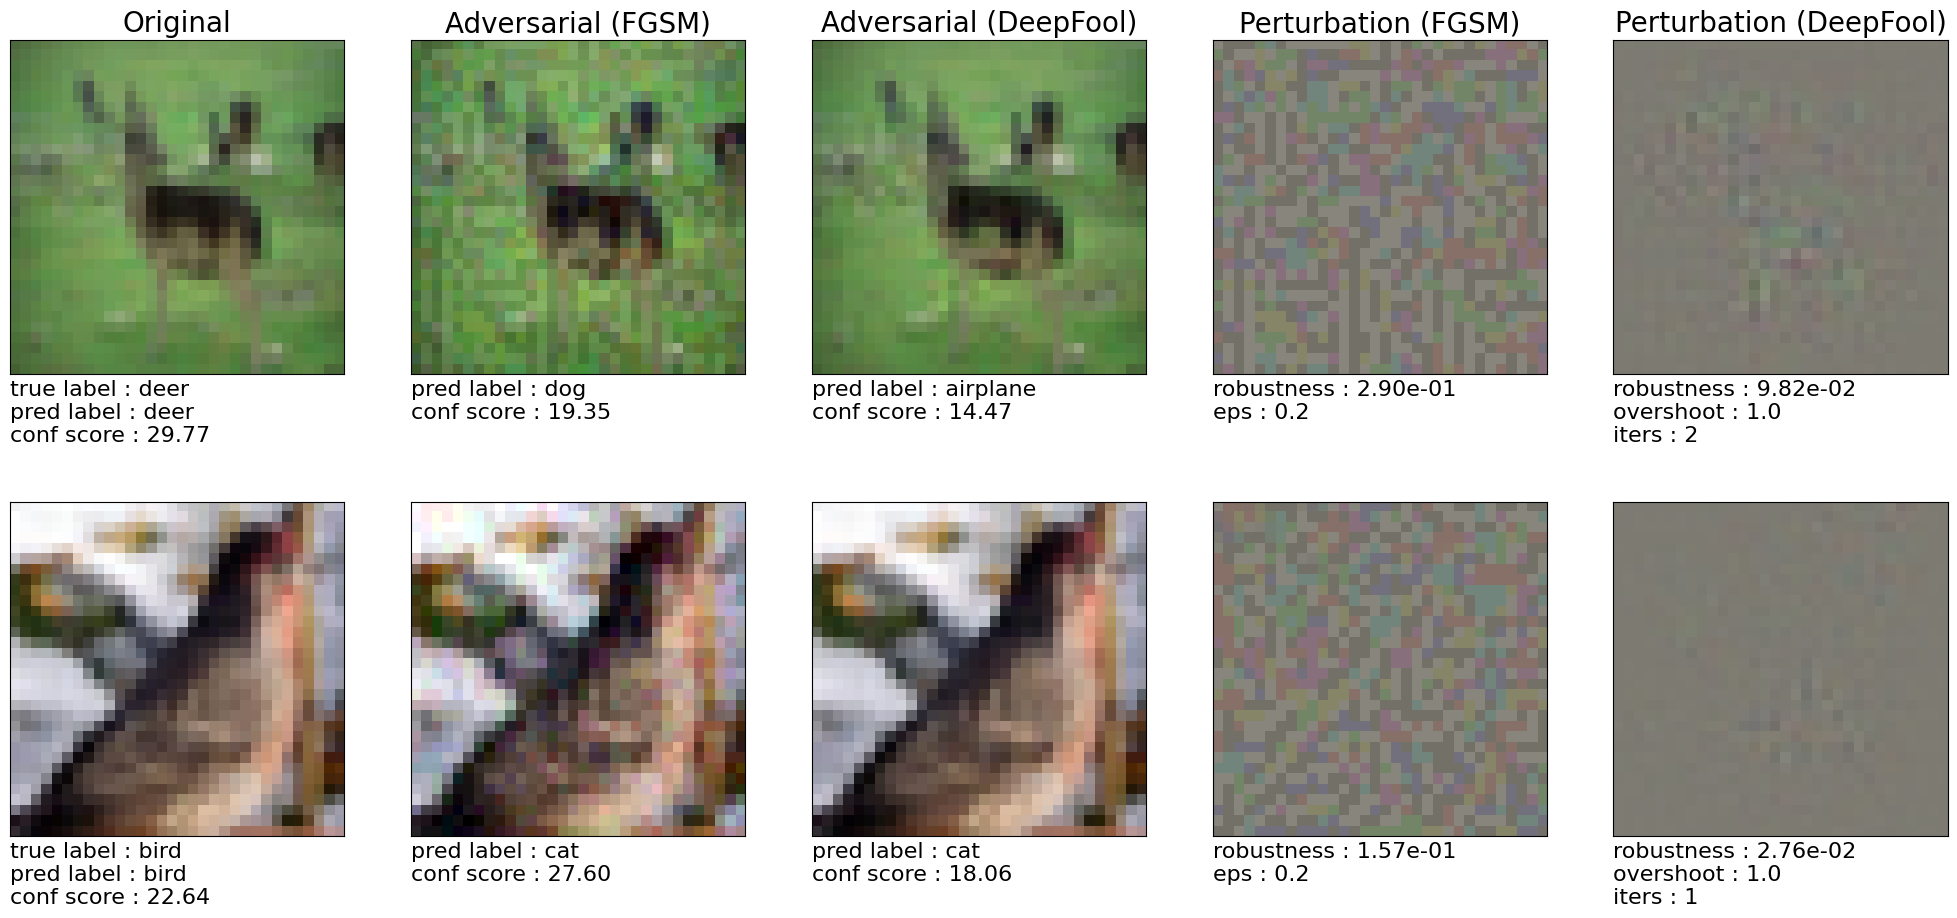

In [36]:
fgsm_eps = 0.2

model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

display_attack(
    device=device,
    model=model,
    test_dataset=cifar_test,
    inv_tf=cifar_tf_inv,
    clip_min=cifar_min,
    clip_max=cifar_max,
    fgsm_eps=fgsm_eps,
    deep_args=deep_args,
    has_labels=False,
    l2_norm=True,
    pert_scale=1.0,
    fig_rows=2,
    fig_width=25,
    fig_height=11,
    label_map=cifar_classes
)

In [37]:
if device.type == 'cuda': torch.cuda.empty_cache()

### LeNet CIFAR-10

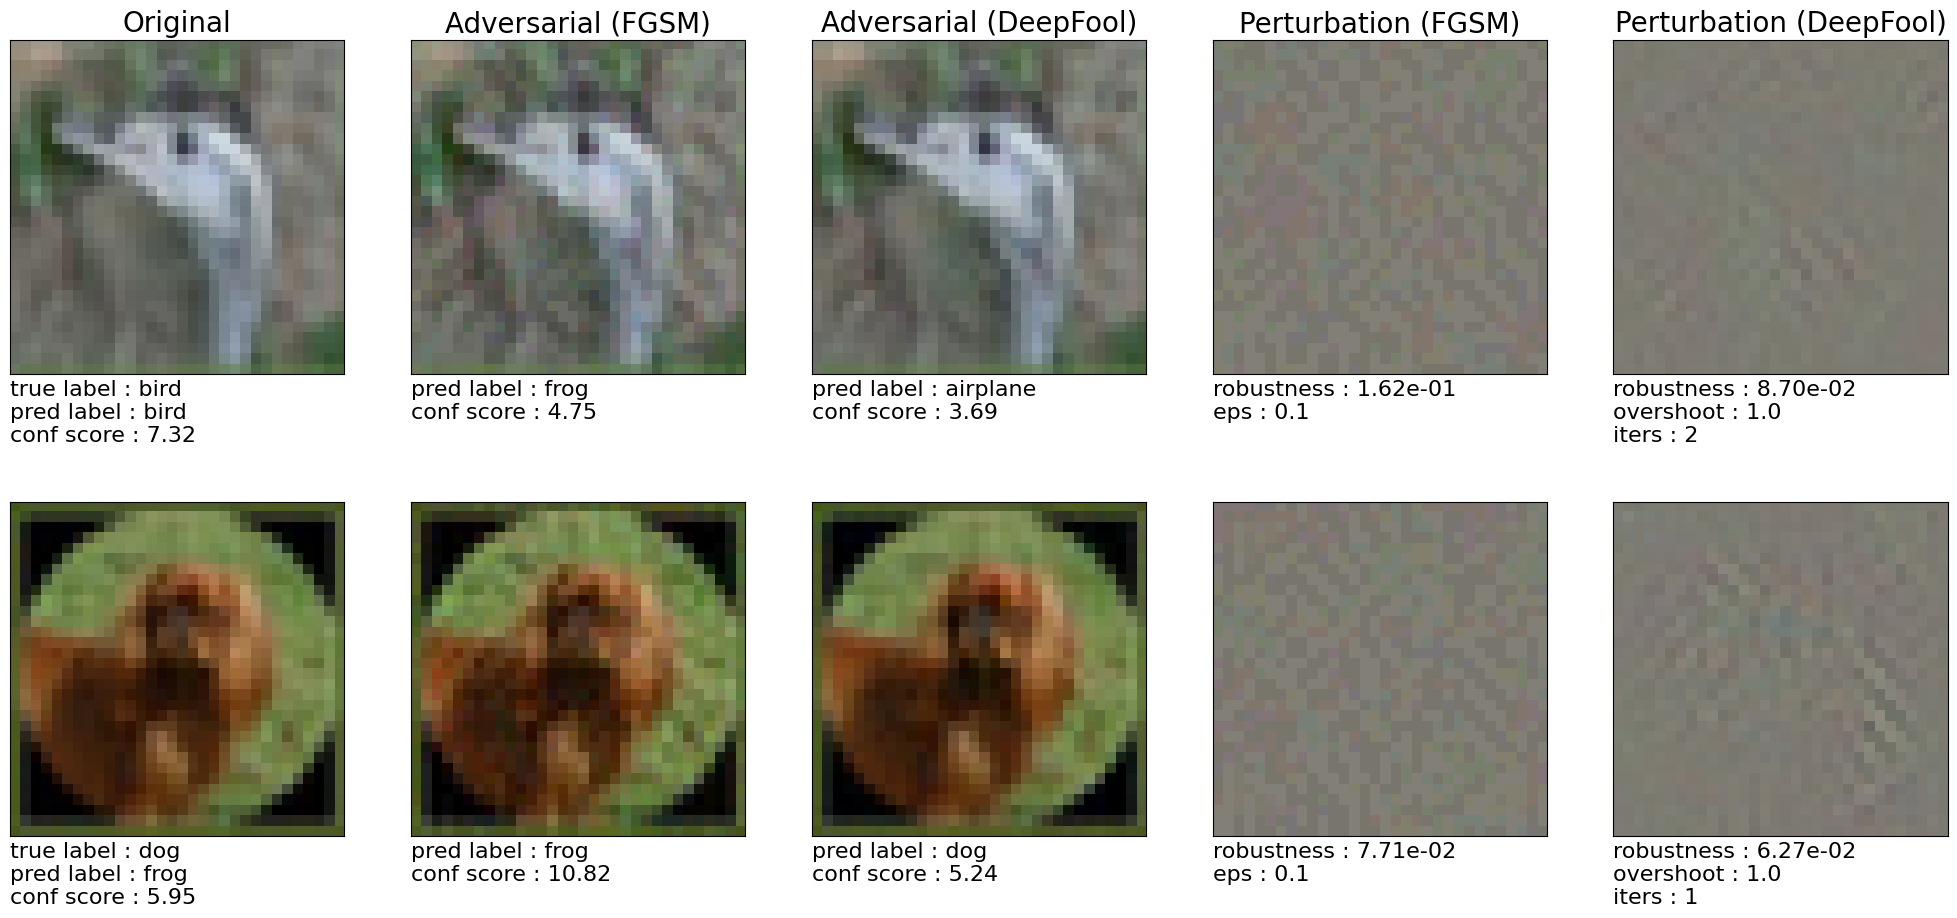

In [38]:
fgsm_eps = 0.1

model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

display_attack(
    device=device,
    model=model,
    test_dataset=cifar_test,
    inv_tf=cifar_tf_inv,
    clip_min=cifar_min,
    clip_max=cifar_max,
    fgsm_eps=fgsm_eps,
    deep_args=deep_args,
    has_labels=False,
    l2_norm=True,
    pert_scale=1.0,
    fig_rows=2,
    fig_width=25,
    fig_height=11,
    label_map=cifar_classes
)

In [39]:
if device.type == 'cuda': torch.cuda.empty_cache()